# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [36]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 定义数据生成器

In [37]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

# 定义网络结构

# 测试生成器

Text(0.5,1,'L6FR')

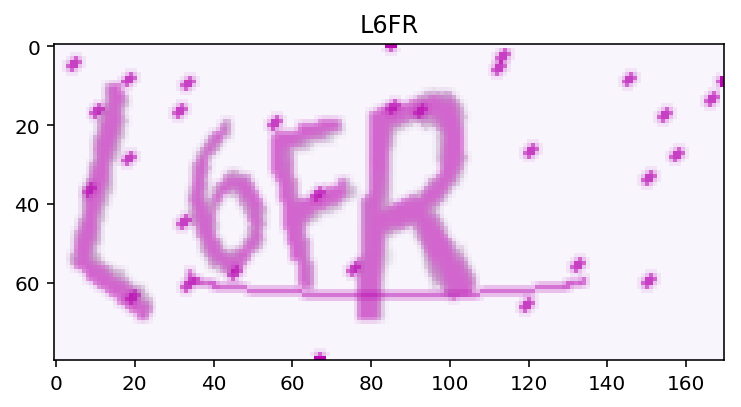

In [38]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [24]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

c:\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys
c:\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
c:\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
c:\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
c:\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  import sys
c:\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  
c:\python36\lib\site-packa

# 网络结构可视化

In [41]:
#from keras.utils.vis_utils import plot
from keras.utils.vis_utils import plot_model

from IPython.display import Image

#plot(model, to_file="model.png", show_shapes=True)
plot_model(model, to_file="model.png")
Image('model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

# 训练模型

In [ ]:
#model.fit_generator(gen(), samples_per_epoch=51200, nb_epoch=5,
#                    validation_data=gen(), nb_val_samples=1280)
model.fit_generator(gen(), steps_per_epoch=5120/、32, nb_epoch=1,
                    validation_data=gen(), validation_steps=10)

c:\python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
c:\python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=160.0, validation_data=<generator..., validation_steps=10, epochs=1)`
  after removing the cwd from sys.path.


Epoch 1/1
 81/160 [==============>...............] - ETA: 7:49 - loss: 62.4463 - c1_loss: 15.5398 - c2_loss: 15.7077 - c3_loss: 15.5522 - c4_loss: 15.6466 - c1_acc: 0.0359 - c2_acc: 0.0255 - c3_acc: 0.0351 - c4_acc: 0.0289

# 测试模型

In [ ]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [ ]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

# 保存模型

In [ ]:
model.save('cnn.h5')